<a href="https://colab.research.google.com/github/metamanna/mushroom-risk-analyzer/blob/main/Assignment5_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# ============================================
# Step 0: Upload Mushroom Dataset
# ============================================

from google.colab import files

# Upload the CSV file (shows upload button)
uploaded = files.upload()

Saving mushrooms.csv to mushrooms (4).csv


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
import pickle

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest

In [61]:
# Load uploaded file
df = pd.read_csv("mushrooms.csv")
print(f"Dataset loaded. Shape: {df.shape}")
df.head()

Dataset loaded. Shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


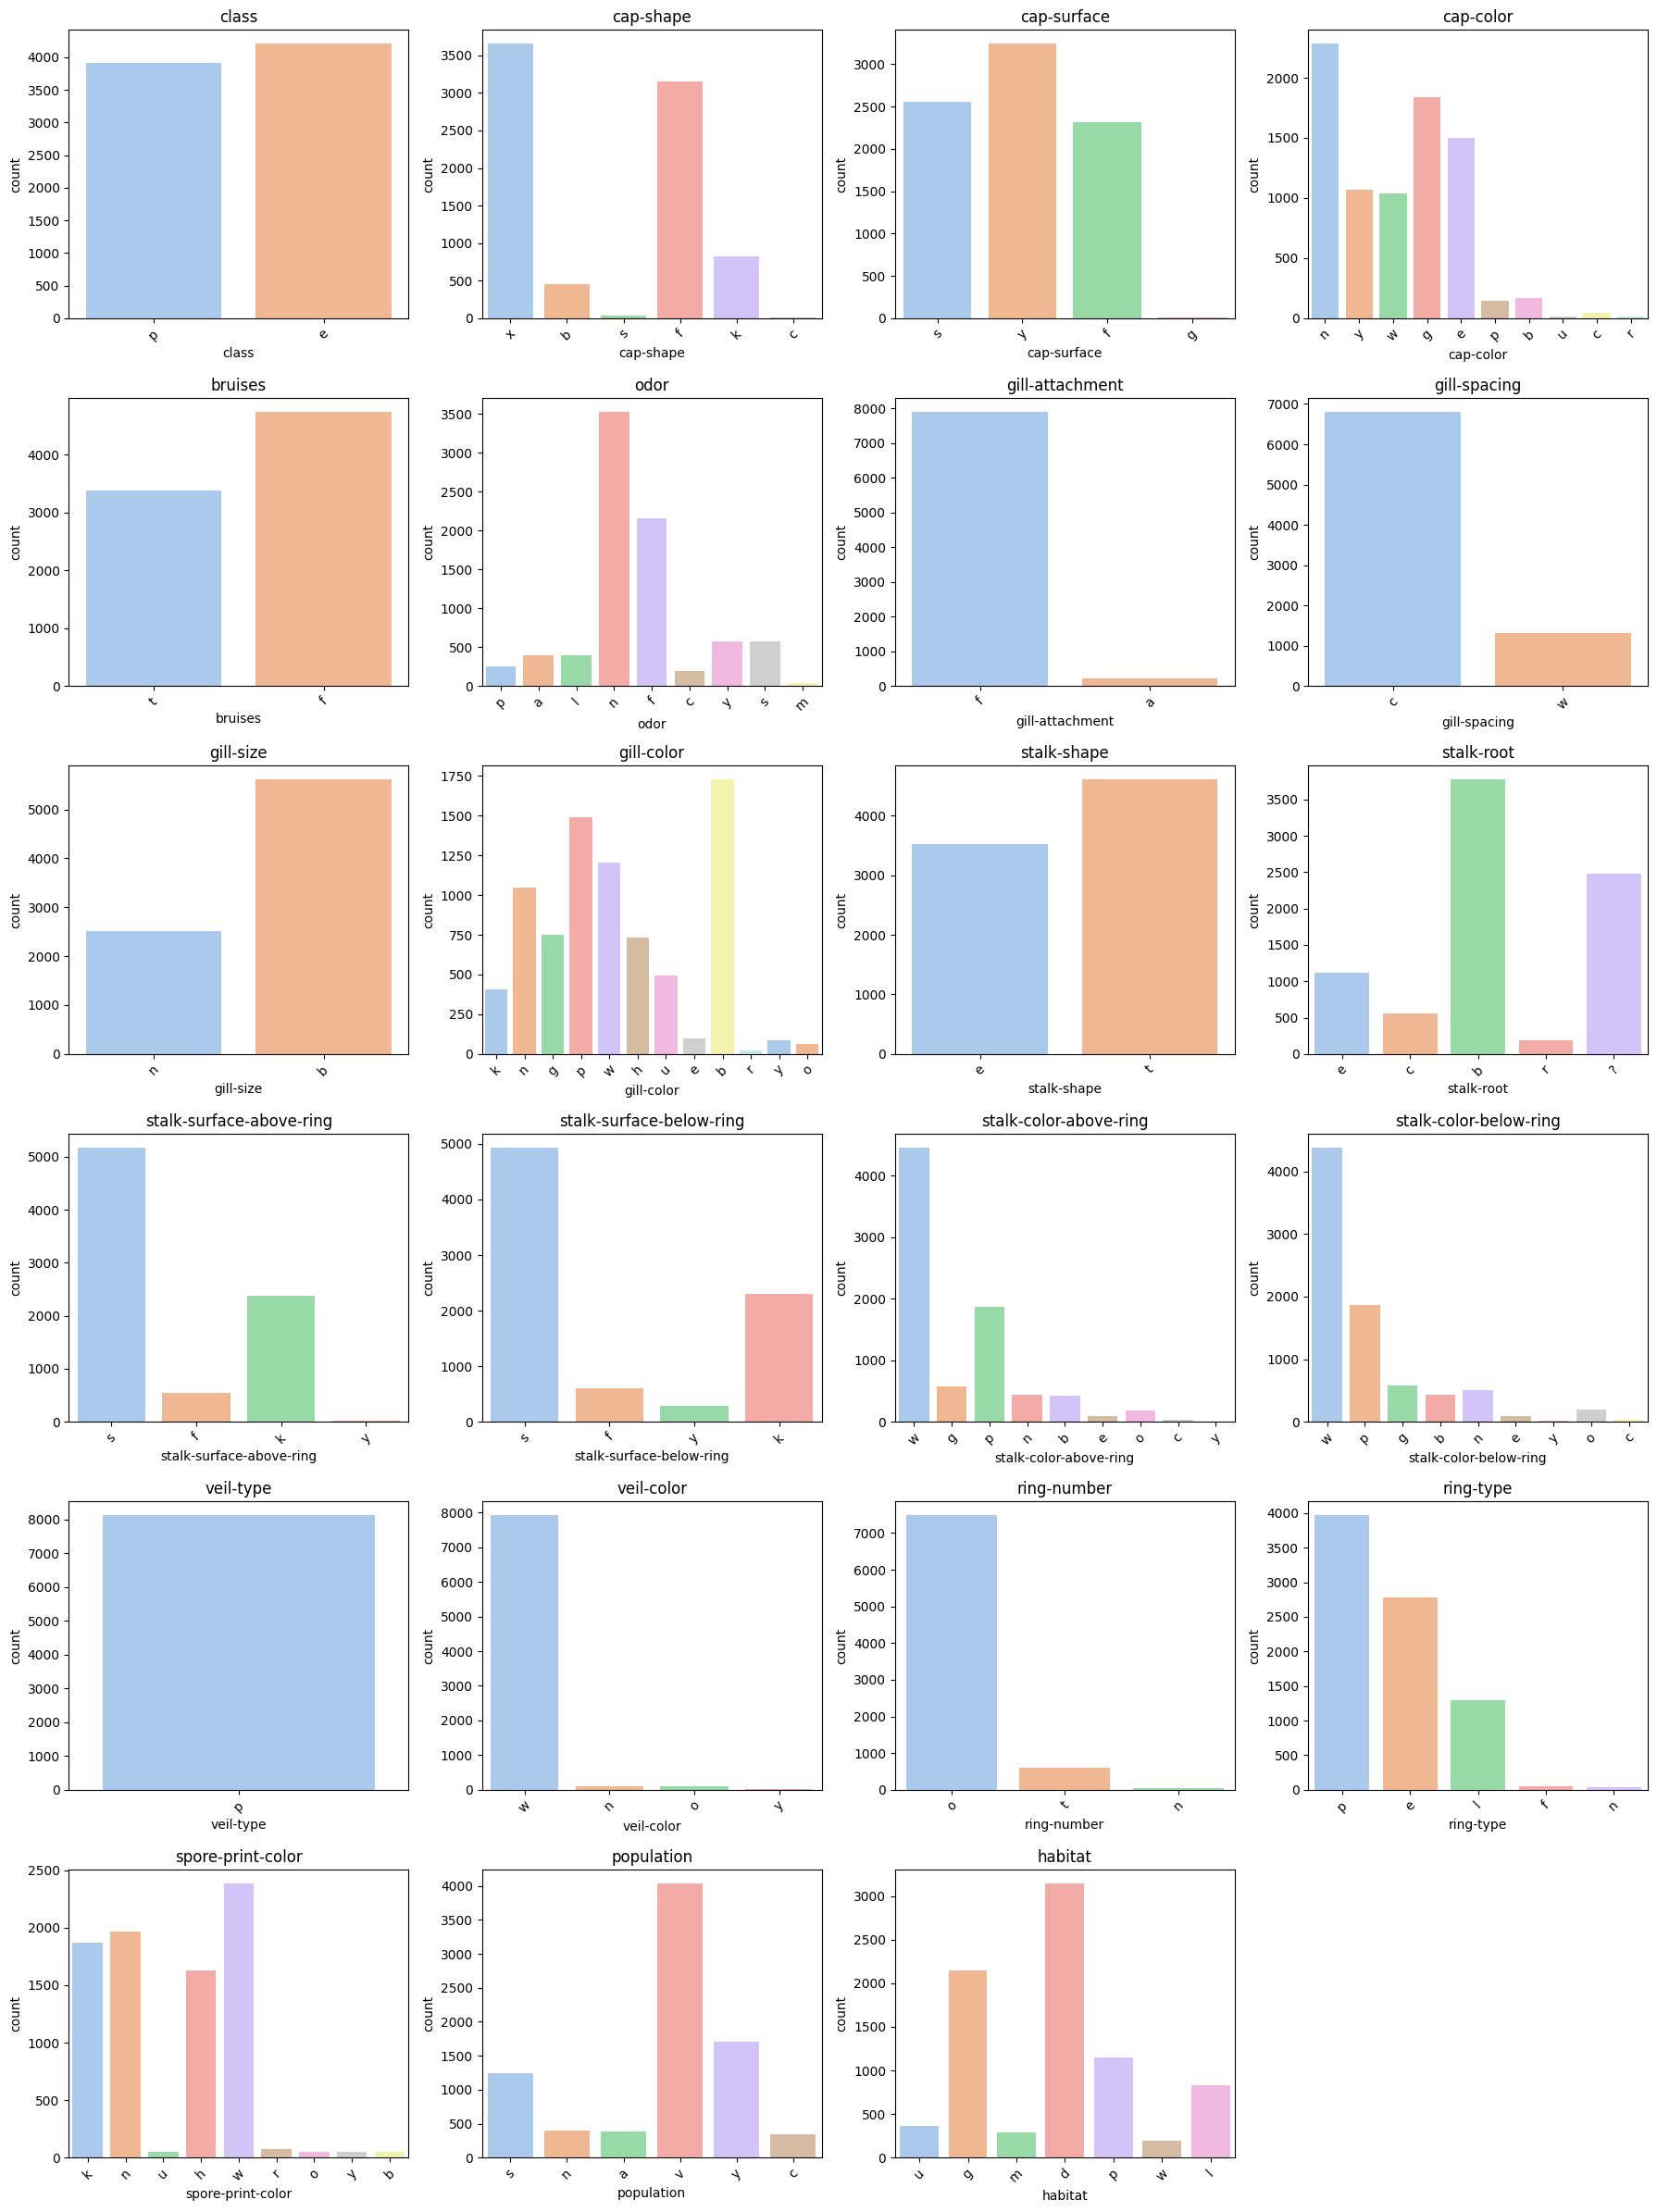

In [62]:
n_cols = 4
n_rows = int(np.ceil(len(df.columns) / n_cols))

plt.figure(figsize=(18, n_rows * 4))

for idx, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, idx + 1)
    sns.countplot(data=df, x=col, hue=df[col], palette='pastel', legend=False)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [63]:
# ============================================
# Drop Duplicate Rows
# ============================================

duplicates = df.duplicated()
print(f"🔁 Duplicate rows found: {duplicates.sum()}")

# Drop them if any
df = df.drop_duplicates()
print(f"Data shape after removing duplicates: {df.shape}")

🔁 Duplicate rows found: 0
Data shape after removing duplicates: (8124, 23)


In [64]:
# ============================================
# Drop Constant Columns
# ============================================

constant_cols = [col for col in df.columns if df[col].nunique() == 1]

if constant_cols:
    print(" Constant columns found:", constant_cols)
    df.drop(columns=constant_cols, inplace=True)
else:
    print(" No constant columns found.")

 Constant columns found: ['veil-type']


In [65]:
# ============================================
# Label Encoding
# ============================================

from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
le = LabelEncoder()

for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

print("All categorical columns encoded.")
df_encoded.head()

All categorical columns encoded.


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


In [66]:
# ============================================
# Train-Test Split
# ============================================

# Features and Target
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Data split complete:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Data split complete:
X_train: (5686, 21), X_test: (2438, 21)
y_train: (5686,), y_test: (2438,)


In [67]:
# ============================================
# Train Multiple Models & Compare
# ============================================
# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': GaussianNB()
}

# Train & evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

# Display results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

print(" Model Performance Comparison:")
results_df

 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,Decision Tree,1.000000,1.000000,1.000000,1.000000
2,KNN,0.997949,0.996604,0.999149,0.997875
3,SVM,0.991386,0.999135,0.982979,0.990991
4,Logistic Regression,0.953651,0.958549,0.944681,0.951565
5,Naive Bayes,0.915915,0.894951,0.935319,0.914690


In [68]:
# ============================================
# Hyperparameter Tuning (Random Forest)
# ============================================
# Define parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Display best params
print("Best Hyperparameters Found:")
print(grid_search.best_params_)

Best Hyperparameters Found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [69]:
y_pred_best = best_rf.predict(X_test)

print("Classification Report (Best RF):")
print(classification_report(y_test, y_pred_best))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

Classification Report (Best RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1263
           1       1.00      1.00      1.00      1175

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix:
[[1263    0]
 [   0 1175]]


In [70]:
# ============================================
# Cross-Validation Score
# ============================================
# Get F1 scores across 5 folds
cv_scores = cross_val_score(best_rf, X, y, cv=5, scoring='f1')
print("Cross-Validated F1 Scores:", cv_scores)
print(f"Average F1 Score: {cv_scores.mean():.4f}")

Cross-Validated F1 Scores: [0.80487805 1.         0.99032882 1.         0.73833098]
Average F1 Score: 0.9067


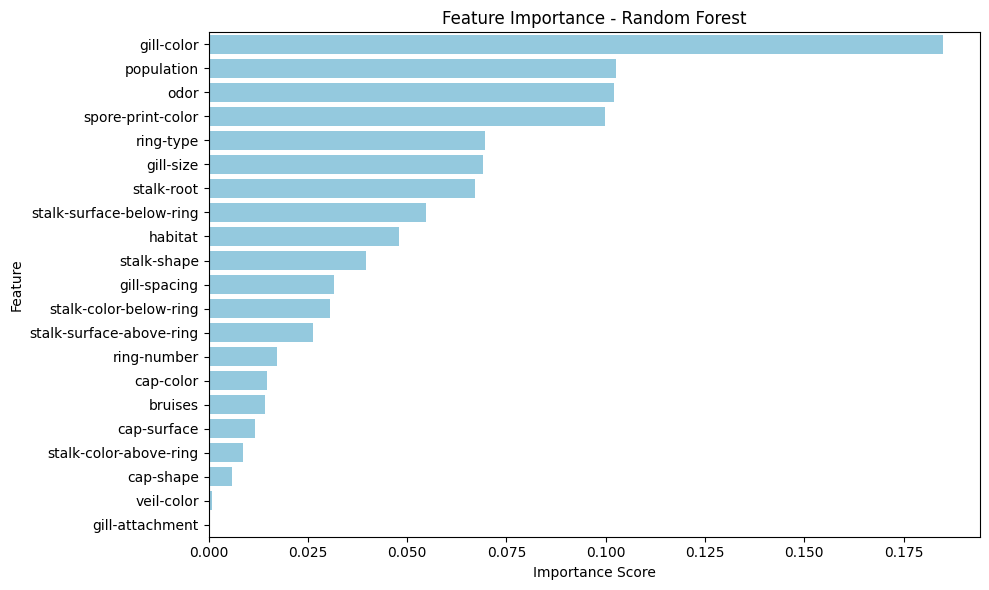

In [71]:
# ============================================
# Feature Importance Plot
# ============================================
# Get importance
importances = best_rf.feature_importances_
features = X.columns

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [72]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [73]:
print("X_test shape:", X_test.shape)
print("shap_values[1] shape:", np.array(shap_values[1]).shape)

X_test shape: (2438, 21)
shap_values[1] shape: (21, 2)


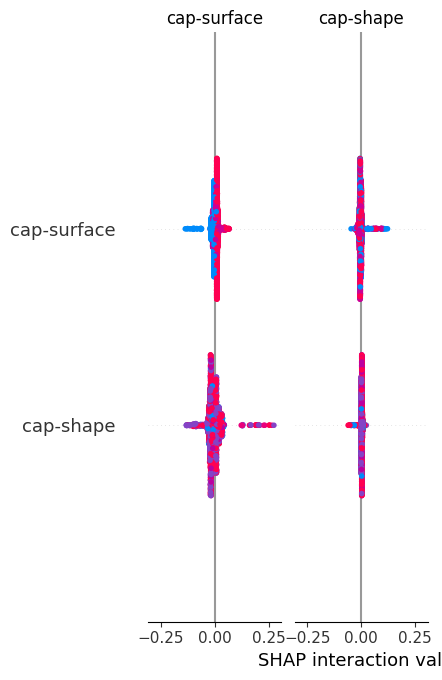

In [74]:
# Recreate a test DataFrame (make sure it's aligned)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Use shap.Explainer instead of TreeExplainer
explainer = shap.Explainer(best_rf, X_train)

# Compute SHAP values
shap_values = explainer(X_test_df)

# Plot summary
shap.summary_plot(shap_values, X_test_df)

In [75]:
# ============================================
# Outlier Detection using Isolation Forest
# ============================================
# Fit Isolation Forest on entire feature set
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_labels = iso_forest.fit_predict(X)

# -1 = outlier, 1 = normal
df_encoded['outlier'] = outlier_labels

# Count outliers
print("Outlier counts:")
print(df_encoded['outlier'].value_counts())

# Display example outliers
print("\nSample Detected Outliers:")
df_encoded[df_encoded['outlier'] == -1].head()

Outlier counts:
outlier
 1    8042
-1      82
Name: count, dtype: int64

Sample Detected Outliers:


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,outlier
4165,0,2,0,1,0,5,1,1,1,10,...,0,7,4,2,1,0,7,4,2,-1
4380,0,5,3,0,1,5,1,0,0,1,...,2,7,2,2,2,0,7,1,6,-1
4459,0,3,3,0,1,5,1,0,0,1,...,2,2,2,2,2,0,7,1,6,-1
4826,1,0,0,9,0,5,1,0,1,10,...,3,7,4,2,1,0,7,4,0,-1
4964,0,2,2,0,1,5,1,0,0,10,...,2,7,2,2,2,0,7,1,6,-1


In [76]:
!pip install gradio --quiet

In [77]:
def predict_mushroom(cap_shape, odor, gill_color, population):
    try:
        # 🔹 Step 1: Form a DataFrame
        input_dict = {
            'cap-shape': [cap_shape],
            'odor': [odor],
            'gill-color': [gill_color],
            'population': [population]
        }
        input_df = pd.DataFrame(input_dict)

        # 🔹 Step 2: Fit-transform full data again (ensure encoder works)
        full_data = pd.read_csv("mushrooms.csv").drop_duplicates()
        le_dict = {}
        for col in input_df.columns:
            le = LabelEncoder()
            le.fit(full_data[col])
            input_df[col] = le.transform(input_df[col])
            le_dict[col] = le  # Save encoder in case needed

        # 🔹 Step 3: Align column order
        input_df = input_df.reindex(columns=best_rf.feature_names_in_)

        # 🔹 Step 4: Predict
        prediction = best_rf.predict(input_df)[0]
        return "🍄 Edible" if prediction == 0 else "☠️ Poisonous"

    except Exception as e:
        # 🚨 Return the error string to debug
        return f"Error: {str(e)}"

In [78]:
import gradio as gr

interface = gr.Interface(
    fn=predict_mushroom,
    inputs=[
        gr.Dropdown(['x','b','s','f','k','c'], label="Cap Shape"),
        gr.Dropdown(['n','f','y','s','l','a','p','c','m'], label="Odor"),
        gr.Dropdown(['k','n','g','p','w','h','u','e','b','r','y','o'], label="Gill Color"),
        gr.Dropdown(['s','n','a','v','y','c'], label="Population")
    ],
    outputs="text",
    title="🍄 Mushroom Edibility Classifier",
    description="Enter mushroom characteristics to check if it's edible or poisonous."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://23d51fda7a9b13fb9c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
